In [6]:
import torch
from torch import autograd
import numpy as np
from typing import Tuple
import torch

In [7]:
a = torch.ones([1,2],requires_grad = True)
b = torch.randn([2,1])
c = torch.mm(a,b)
c.backward()

In [8]:
a.grad

tensor([[-1.5705, -0.1593]])

In [9]:
seed = 1
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [48]:
from typing import Tuple

def sgd_factorise_ad(A:torch.tensor, rank:int, numepochs = 1000, lr = 0.01)->(torch.tensor, torch.tensor):
    [m,n] = A.shape
    torch.manual_seed(seed)

    U = torch.rand(m,rank,requires_grad = True)
    V = torch.rand(n,rank,requires_grad = True)
    for epoch in range(numepochs):
        U.grad=None
        V.grad=None
        
        loss = torch.nn.functional.mse_loss(A, torch.mm(U,V.t()), reduction='sum')
        loss.backward()
        
        #print()
        U.data = U - lr * U.grad
        #U.data = U_
        V.data = V - lr * V.grad
        #V.data = V_
        
        
        if epoch%100 == 0:
            print('epoch:', epoch, 'loss:', loss.item())
    return (U, V)


A = torch.tensor([[0.3374, 0.6005, 0.1735],
                  [3.3359, 0.0492, 1.8374],
                  [2.9407, 0.5301, 2.2620]])

(U,V) = sgd_factorise_ad(A,2)
#print(U,V)
torch.nn.functional.mse_loss(A, torch.mm(U,V.t()))

epoch: 0 loss: 17.55448341369629
epoch: 100 loss: 0.23555728793144226
epoch: 200 loss: 0.14199630916118622
epoch: 300 loss: 0.12693637609481812
epoch: 400 loss: 0.12319667637348175
epoch: 500 loss: 0.1222386509180069
epoch: 600 loss: 0.12199428677558899
epoch: 700 loss: 0.12193208187818527
epoch: 800 loss: 0.1219162568449974
epoch: 900 loss: 0.12191219627857208


tensor(0.0135, grad_fn=<MeanBackward0>)

# Iris dataset

In [2]:
import pandas   as   pd
df  =  pd.read_csv ('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
data = torch.tensor(df.iloc[:,[0,1,2,3]].values)
data = data - data.mean(dim=0)

NameError: name 'torch' is not defined

$SGD$

In [108]:
(U,V) = sgd_factorise_ad(data,2)
print('Loss:',torch.nn.functional.mse_loss(data, torch.mm(U,V.t())).item())

epoch: 0 loss: 820.5762200622535
epoch: 100 loss: 51.11466896539471
epoch: 200 loss: 50.27467391896267
epoch: 300 loss: 45.85877841798051
epoch: 400 loss: 32.28319538176266
epoch: 500 loss: 19.705431018248685
epoch: 600 loss: 16.02441304370252
epoch: 700 loss: 15.36057934619984
epoch: 800 loss: 15.251112326118085
epoch: 900 loss: 15.232809160610875
Loss: 0.025382665811185288


$SVD$

In [109]:
A = data.data

U,Σ,V= torch.svd(A)
t = 2
Σ = torch.diag(Σ[0:t])
U=U[:,0:t]
V=V[:,0:t]

A_tilde = U @ Σ @ V.t()
print('Loss:',torch.nn.functional.mse_loss(A, A_tilde).item())

Loss: 0.025381388913005544


Text(0.5, 1.0, 'SVD')

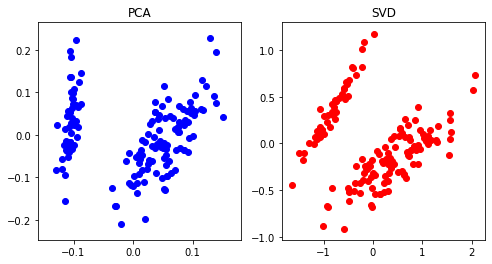

In [252]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(nrows=1,ncols=2, figsize = (8,4))

ax[0].scatter(U[:,0], -U[:,1], c = 'b')
ax[0].set_title('PCA')
ax[1].scatter(A_tilde[:,0],A_tilde[:,1], c = 'r')
ax[1].set_title('SVD')


when I turn the scatter plot of SVD up and down, they become similar to each other.
These orthogonal linear transforms project a matrix to lower dimensional space so that it can be described by lower-dimension matrices(or vectors) with least information loss. Furthermore, These transforms denoise the matrix in each original dimension.

# MLP

In [4]:
import pandas as pd
import torch
df  =  pd.read_csv ('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df = df.sample(frac=1)#shuffle


#add label indices column
mapping = {k:v for v,k in enumerate(df[4].unique())}
df[5]=df[4].map(mapping)

#normalise data
alldata = torch.tensor(df.iloc[:,[0,1,2,3]].values,dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0))/alldata.var(dim=0)


#create datasets
targetstr=torch.tensor(df.iloc[:100,5].values,dtype=torch.long) #training set
targetsva=torch.tensor(df.iloc[100:,5].values,dtype=torch.long) #validation set
datatr=alldata[:100]
datava=alldata[100:]

# datatr = datatr.unsqueeze(0)
# datava = datava.unsqueeze(0)

In [6]:
datava.shape

torch.Size([50, 4])

In [277]:
import torch.nn.functional as F

def MLP(data, W1, b1, W2, b2):
    return torch.relu(data @ W1 + b1) @ W2 + b2

def train(data, lr = 0.01, numepochs = 100):
    assert data.shape[1] == 4
    W1 = torch.rand((4,12), requires_grad = True)
    W2 = torch.rand((12,3), requires_grad = True)
    b1 = torch.tensor([0.0], requires_grad = True)
    b2 = torch.tensor([0.0], requires_grad = True)
    for epoch in range(numepochs):
        logits = MLP(data, W1, b1, W2, b2)
        loss = F.cross_entropy(logits, targetstr)        
        loss.backward()
        #update
        W1.data = W1.data - W1.grad * lr
        W2.data = W2.data - W2.grad * lr
        b1.data = b1.data - b1.grad * lr
        b2.data = b2.data - b2.grad * lr
        
        if (epoch)%250==0:
            print('epoch',epoch,' loss:',loss.item())
            
    return W1,b1,W2,b2  
    
def evaluate(data, targets, W1, b1, W2, b2):
    assert data.shape[1] == 4
    logits = MLP(data, W1, b1, W2, b2)
    pred = torch.max(logits,1)
    a = torch.eq(pred[1], targets, out=None)
    print('acc:',float(a.sum())/float(a.shape[0]))
    return pred[1]
    
    
W1, b1, W2, b2 = train(datatr,0.002,2000)
print('training ', end = '')
evaluate(datatr,targetstr, W1, b1, W2, b2)
print('validation ', end = '')
evaluate(datava,targetsva, W1, b1, W2, b2)



epoch 0  loss: 0.9812206029891968
epoch 250  loss: 0.06764069944620132
epoch 500  loss: 0.053915757685899734
epoch 750  loss: 0.04093702882528305
epoch 1000  loss: 1.1086402196269773e-07
epoch 1250  loss: 0.00037317140959203243
epoch 1500  loss: 0.002805523807182908
epoch 1750  loss: 0.0020774754229933023
training acc: 1.0
validation acc: 0.98


tensor([0, 2, 2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2,
        0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 0,
        2, 1])

 model not stable since its default lr is too high, which dependent too much of decent initial weights.
 
 however, if lr is tuned down to 0.001 and epoch up 20 times to 2000, tr acc and va acc stablise quite a lot.
 they are both fluctuating around 95%~99% and the former is slightly lower by 1-8%. 